In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%load_ext Cython

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [ ]:
%%cython
import cython
from libc.math cimport sqrt
import numpy as np
cimport numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from cython.parallel import prange

from cython import boundscheck, wraparound

@boundscheck(False)
@wraparound(False)

cpdef KNN_cython_prange(double[:, ::1] X_train, double[:, ::1] X_test, long[:] y_train, int k):
    cdef int X_train_rows = X_train.shape[0]
    cdef int X_test_rows = X_test.shape[0]
    cdef int X_dim = X_train.shape[1]
    cdef double[:, ::1] list_dist = np.zeros([X_test_rows, X_train_rows])
    cdef double[:, ::1] idx = np.zeros([X_test_rows, k])
    cdef double[:] predictions = np.zeros(X_test_rows)
    
    cdef int i, j, l, e
    cdef double dist

    for i in prange(X_test_rows, nogil = True):
        for j in range(X_train_rows):
            dist = 0.0
            for l in range(X_dim):
                dist = dist + (X_train[j,l] - X_test[i,l])**2
            list_dist[i,j] = sqrt(dist)
    e = 0
    
    for elements in list_dist:
        temp = [np.argsort(elements)[:k]]
        for j in range(k):
            idx[e,j] = y_train[temp[0][j]]  
        if np.sum(idx[e])>k//2:
            predictions[e] = 1
        else:
            predictions[e] = 0
        e +=1 
        
    return np.asarray(predictions)

In [ ]:
def KNN_python(X_train, X_test, y_train,k):
    list_dist = []
    for x in X_test:
        dist = []
        for i in range(len(X_train)):
            dist.append(np.sqrt(np.sum((x-X_train[i,:])**2)))
        list_dist.append(dist)
    
    idx = []
    for elements in list_dist:
        idx.append([np.argsort(elements)[:k]])
        
    labels =  []
    for elements in idx:
        labels.append([y_train[elements[i]] for i in range(len(elements))])
    
    
    predictions = []
    for elements in labels:
        if np.sum(elements) > k//2:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from tqdm import tqdm

time_list_cython = []
time_list_python = []
count_list = []

# Tailles des jeux de données à tester
n_samples=[50,500,1000,3000,6000,10000,15000,20000]

count_list = []
time_list_cython=[]
time_list_python = []
for n in tqdm(n_samples):
    # Création du dataset 
    X, y = make_classification(
      n_samples=n,
      n_features=30,
      n_informative=7,
      n_redundant=0,
      n_classes=2,
      random_state=42,
    )
    
    # Division du jeu de données en X_test et X_train
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # KNN en Python
    start = time.time()
    KNN_cython_prange(X_train, X_test, y_train,k = 5)
    end = time.time()
    # Stockage du temps d'exécution
    time_list_cython.append(end-start)
    
    # KNN en Cython
    start = time.time()
    KNN_python(X_train, X_test, y_train,k=5)
    end = time.time()
    # Stockage du temps d'exécution
    time_list_python.append(end-start)
    
    count_list.append(n)   

100%|██████████| 8/8 [23:04<00:00, 173.11s/it]


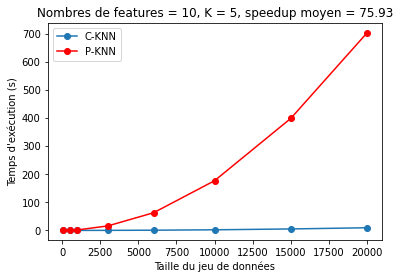

In [ ]:
# Plot de la taille du jeu de données en fonction tu temps d'exécution
plt.plot(count_list,time_list_cython, '-o', label='C-KNN')
plt.plot(count_list,time_list_python, '-o', c='r', label='P-KNN')
plt.xlabel("Taille du jeu de données")
plt.ylabel("Temps d'exécution (s)")
plt.legend()
plt.title('Nombres de features = '+str(10)+', K = '+str(5)+ ', speedup moyen = '+'%0.2f' % (np.mean(time_list_python)/np.mean(time_list_cython)))
plt.show()

In [ ]:
df = pd.DataFrame({'N' :count_list, 'time_python' : time_list_python,'time_cython': time_list_cython})
df['speedup'] = df['time_python'] / df['time_cython']
df

,N,time_python,time_cython,speedup
0,50,0.004671,0.000499,9.356734
1,500,0.457839,0.006475,70.706396
2,1000,1.694978,0.021982,77.106018
3,3000,15.955729,0.199463,79.993278
4,6000,62.882777,0.785677,80.036453
5,10000,176.939175,2.188187,80.861098
6,15000,398.798407,5.207020,76.588613
7,20000,703.252762,9.501407,74.015643


In [ ]:
%%cython
import cython
from libc.math cimport sqrt
import numpy as np
cimport numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np


cpdef KNN_cython(double[:, ::1] X_train, double[:, ::1] X_test, long[:] y_train, int k):
    cdef int X_train_rows = X_train.shape[0]
    cdef int X_test_rows = X_test.shape[0]
    cdef int X_dim = X_train.shape[1]
    cdef double[:, ::1] list_dist = np.zeros([X_test_rows, X_train_rows])
    cdef double[:, ::1] idx = np.zeros([X_test_rows, k])
    cdef double[:] predictions = np.zeros(X_test_rows)
    
    cdef int i, j, l, e
    cdef double dist

    for i in range(X_test_rows):
        for j in range(X_train_rows):
            dist = 0.0
            for l in range(X_dim):
                dist += (X_train[j,l] - X_test[i,l])**2
            list_dist[i, j] = sqrt(dist)
    e = 0
    
    for elements in list_dist:
        temp = [np.argsort(elements)[:k]]
        for j in range(k):
            idx[e,j] = y_train[temp[0][j]]  
        if np.sum(idx[e])>k//2:
            predictions[e] = 1
        else:
            predictions[e] = 0
        e +=1 
        
    return np.asarray(predictions)




In [ ]:
from tqdm import tqdm

time_list_cython = []
time_list_cython_par = []
count_list = []

# Tailles des jeux de données à tester
n_samples=[50,500,1000,3000,6000,10000,15000,20000]

count_list = []
time_list_cython=[]
time_list_python = []
for n in tqdm(n_samples):
    # Création du dataset 
    X, y = make_classification(
      n_samples=n,
      n_features=30,
      n_informative=7,
      n_redundant=0,
      n_classes=2,
      random_state=42,
    )
    
    # Division du jeu de données en X_test et X_train
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # KNN en Cython
    start = time.time()
    KNN_cython(X_train, X_test, y_train,k = 5)
    end = time.time()
    # Stockage du temps d'exécution
    time_list_cython.append(end-start)
    
    # KNN en Python
    start = time.time()
    KNN_cython_prange(X_train, X_test, y_train,k=5)
    end = time.time()
    # Stockage du temps d'exécution
    time_list_cython_par.append(end-start)
    
    count_list.append(n)   

100%|██████████| 8/8 [00:42<00:00,  5.29s/it]


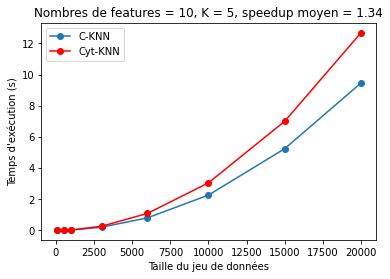

In [ ]:
# Plot de la taille du jeu de données en fonction tu temps d'exécution
plt.plot(count_list,time_list_cython_par, '-o', label='C-KNN')
plt.plot(count_list,time_list_cython, '-o', c='r', label='Cyt-KNN')
plt.xlabel("Taille du jeu de données")
plt.ylabel("Temps d'exécution (s)")
plt.legend()
plt.title('Nombres de features = '+str(10)+', K = '+str(5)+ ', speedup moyen = '+'%0.2f' % (np.mean(time_list_cython)/np.mean(time_list_cython_par)))
plt.show()

In [ ]:
df = pd.DataFrame({'N' :count_list, 'time_cython' : time_list_cython,'time_cython_par': time_list_cython_par})
df['speedup'] = df['time_cython'] / df['time_cython_par']
df

,N,time_cython,time_cython_par,speedup
0,50,0.001086,0.000342,3.174216
1,500,0.008462,0.006521,1.297554
2,1000,0.030122,0.022974,1.311115
3,3000,0.267939,0.207407,1.291854
4,6000,1.091887,0.805967,1.354754
5,10000,3.052394,2.267352,1.346238
6,15000,7.008870,5.248217,1.335476
7,20000,12.687019,9.465126,1.340396
